In [1]:
# Importing Data Science Libraries
import requests
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

from geopy.distance import geodesic

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import contextily as ctx

import geopandas as gpd
import geoplot
from shapely.geometry import Point, Polygon
import mapclassify as mc

import missingno as msno # missing data heatmap
from bs4 import BeautifulSoup
import zipfile

import warnings
# Ignore warning messages
warnings.filterwarnings('ignore')

Importing the Dataset

In [41]:
bike_raw = pd.read_csv("raw data/bike_raw.csv")
bike_raw.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,REF
0,F96D5A74A3E41399,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,TA1309000058,Hampden Ct & Diversey Ave,202480.0,41.924074,-87.646278,41.930000,-87.640000,member,202301
1,13CB7EB698CEDB88,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301
2,BD88A2E670661CE5,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,RP-005,Valli Produce - Evanston Plaza,599,42.008571,-87.690483,42.039742,-87.699413,casual,202301
3,C90792D034FED968,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301
4,3397017529188E8A,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,TA1309000037,Greenwood Ave & 47th St,TA1308000002,41.799568,-87.594747,41.809835,-87.599383,member,202301


In [42]:
print(bike_raw.info())
print(bike_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6389601 entries, 0 to 6389600
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ride_id             object 
 1   rideable_type       object 
 2   started_at          object 
 3   ended_at            object 
 4   start_station_name  object 
 5   start_station_id    object 
 6   end_station_name    object 
 7   end_station_id      object 
 8   start_lat           float64
 9   start_lng           float64
 10  end_lat             float64
 11  end_lng             float64
 12  member_casual       object 
 13  REF                 int64  
dtypes: float64(4), int64(1), object(9)
memory usage: 682.5+ MB
None
          start_lat     start_lng       end_lat       end_lng           REF
count  6.389601e+06  6.389601e+06  6.381609e+06  6.381609e+06  6.389601e+06
mean   4.190251e+01 -8.764702e+01  4.190284e+01 -8.764719e+01  2.023170e+05
std    4.529345e-02  2.734221e-02  5.374774e-02  6.607247e-02 

Data Cleaning and Transformation

In [43]:
#Fixing Data Types and Removing Duplicates
def preprocess_data(df):
    # Convert 'started_at' and 'ended_at' to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    # Return the processed dataframe
    return df

bike_raw = preprocess_data(bike_raw)

# Dropping Irrelevant Columns
def drop_columns(df, cols_to_drop):
    df = df.drop(cols_to_drop, axis=1)
    return df

cols_to_drop = ['start_station_id', 'end_station_id', 'ride_id', 'member_casual', 'REF']
bike_raw = drop_columns(bike_raw, cols_to_drop)

In [44]:
print(bike_raw.info())
bike_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6389601 entries, 0 to 6389600
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   rideable_type       object        
 1   started_at          datetime64[ns]
 2   ended_at            datetime64[ns]
 3   start_station_name  object        
 4   end_station_name    object        
 5   start_lat           float64       
 6   start_lng           float64       
 7   end_lat             float64       
 8   end_lng             float64       
dtypes: datetime64[ns](2), float64(4), object(3)
memory usage: 438.7+ MB
None


,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng
0,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,Hampden Ct & Diversey Ave,41.924074,-87.646278,41.930000,-87.640000
1,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383
2,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,Valli Produce - Evanston Plaza,42.008571,-87.690483,42.039742,-87.699413
3,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383
4,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383


                    Missing Ratio
end_station_name        15.998526
start_station_name      15.064384
end_lat                  0.125078
end_lng                  0.125078


<Axes: >

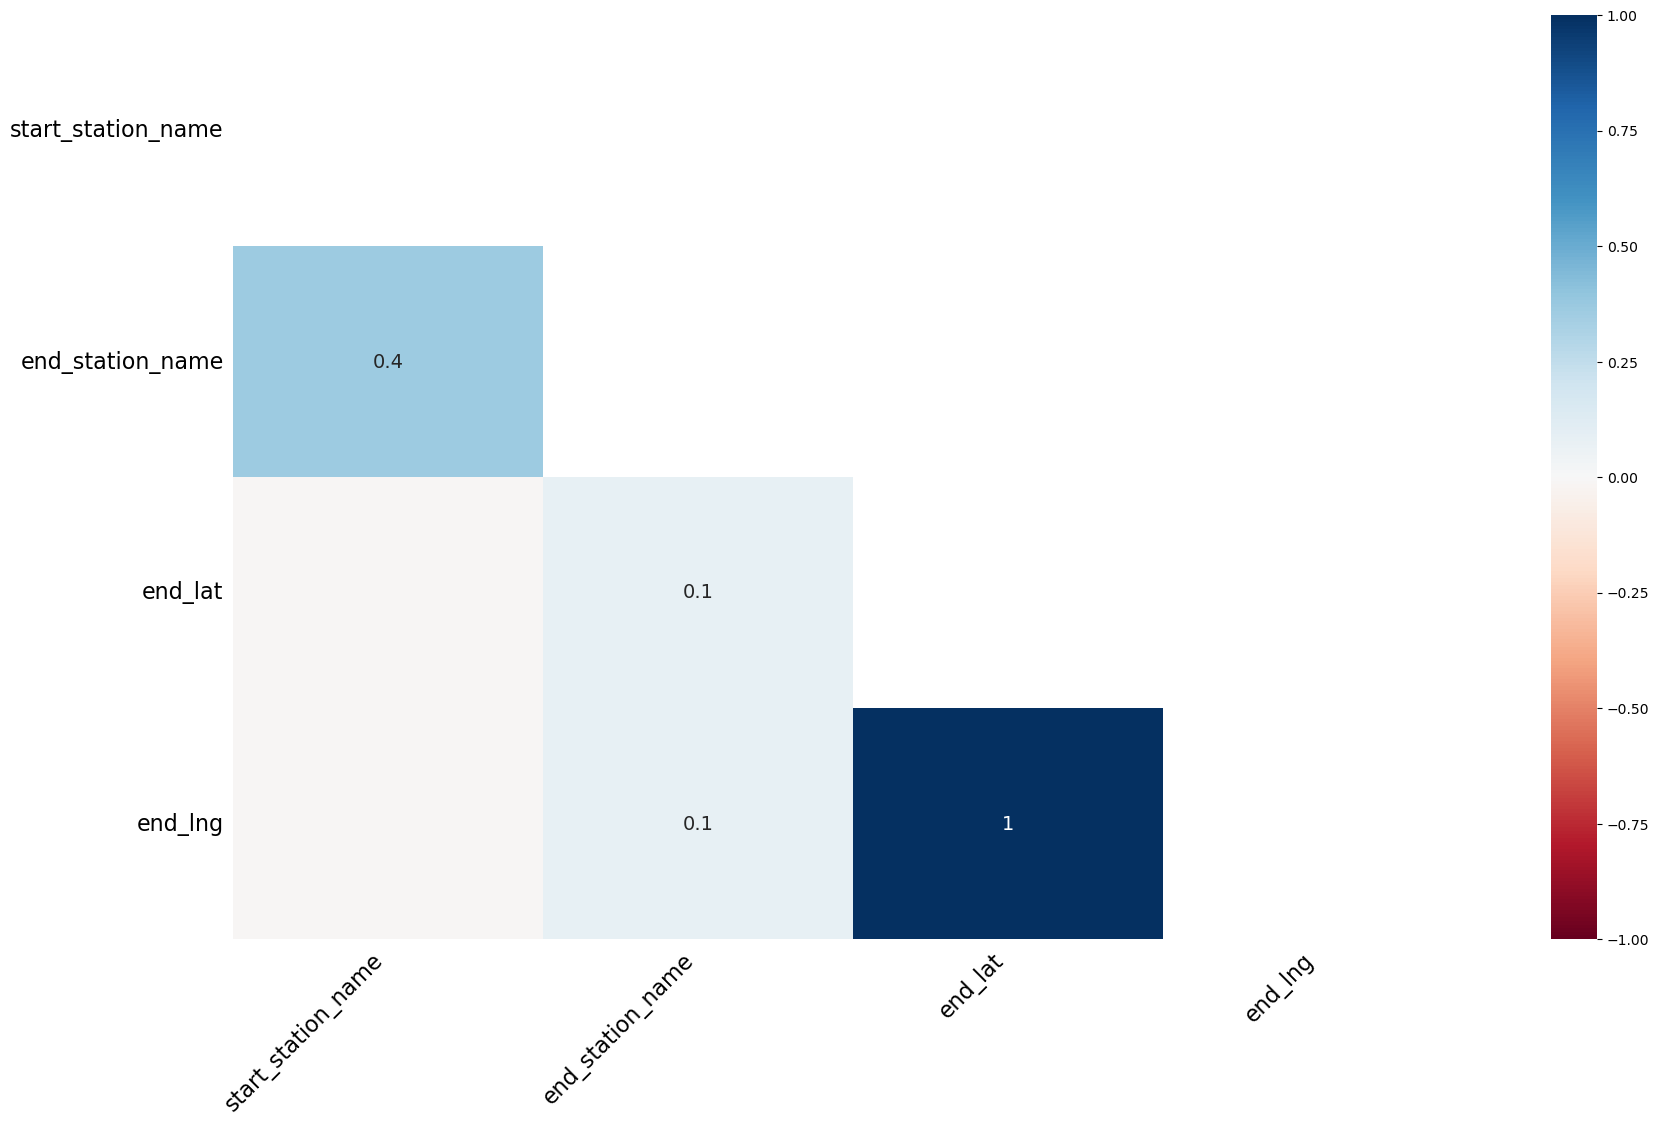

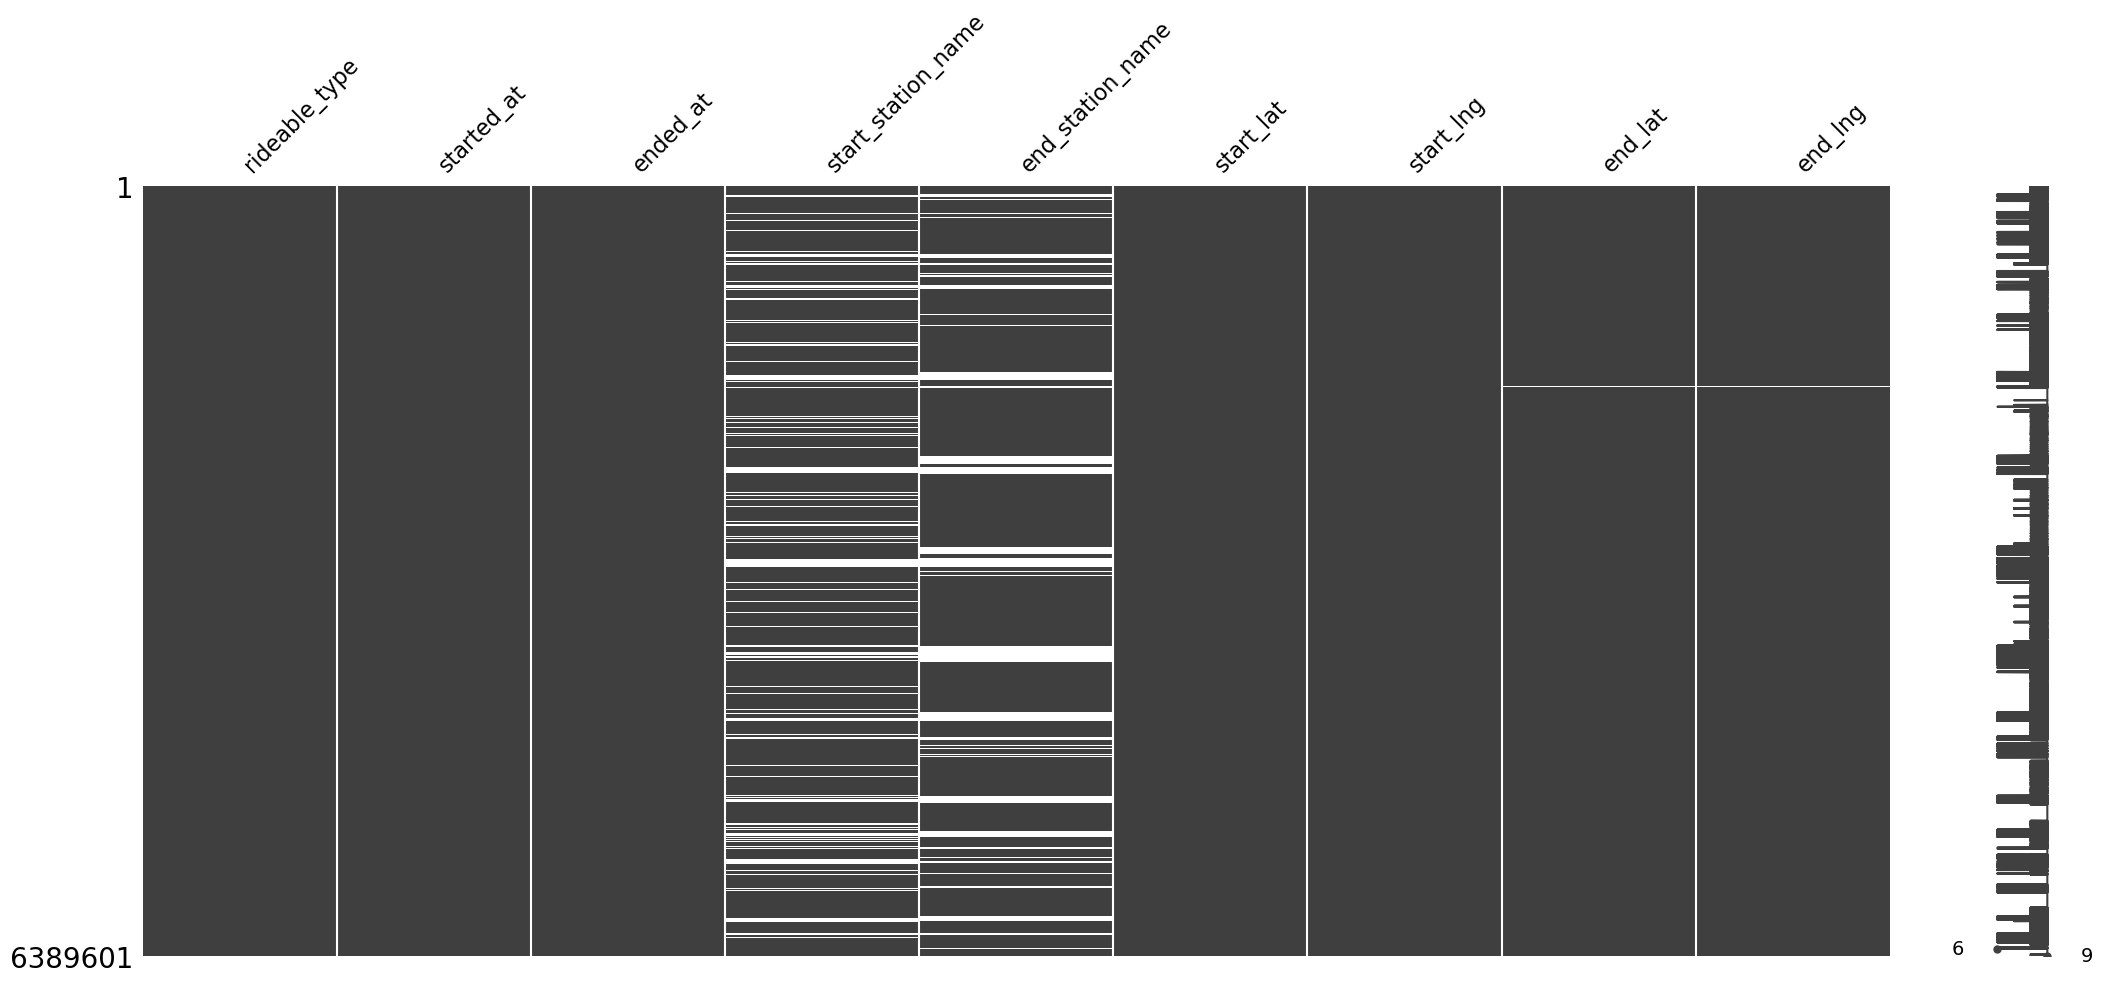

In [45]:
def check_missing_values(data):
    data_na = (data.isnull().sum() / len(data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio': data_na})
    return missing_data

missing_data = check_missing_values(bike_raw)
print(missing_data)

msno.heatmap(bike_raw) # missing data heatmap
msno.matrix(bike_raw) # missing data matrix

In [46]:
# Check if 'end_lat' and 'end_station_name' are missing at the same time
missing_end_lat_rows = bike_raw[bike_raw['end_lat'].isnull()]
missing_end_name_with_lat = missing_end_lat_rows['end_station_name'].isnull().all()

print(missing_end_name_with_lat)

# Delete lines where 'end_lat', 'end_lng' and 'end_station_name' are all missing.
bike_raw = bike_raw.dropna(subset=['end_lat', 'end_lng', 'end_station_name'], how='all')

print(bike_raw.shape)

False
(6381725, 9)


In [47]:
missing_data = check_missing_values(bike_raw)
missing_data

,Missing Ratio
end_station_name,15.894856
start_station_name,15.082975
end_lat,0.001818
end_lng,0.001818


In [49]:
bike_raw.to_csv('preprocessing process data/bikePre_Step1.csv', index=False)

Station Information Extraction

In [50]:
bikePre_Step1 = pd.read_csv("preprocessing process data/bikePre_Step1.csv")

In [51]:
# Extract station name, ID and latitude/longitude columns for start and end stations
start_station_data = bikePre_Step1[['start_station_name', 'start_lat', 'start_lng']]
end_station_data = bikePre_Step1[['end_station_name', 'end_lat', 'end_lng']]

# Rename column
start_station_data.columns = ['station_name', 'lat', 'lng']
end_station_data.columns = ['station_name', 'lat', 'lng']

# Merge start and end station data
combined_station_data = pd.concat([start_station_data, end_station_data])
combined_station_data = combined_station_data.sort_values(by=['station_name', 'lat', 'lng'])
combined_station_data

,station_name,lat,lng
2860267,2112 W Peterson Ave,41.991028,-87.683634
2161229,2112 W Peterson Ave,41.991056,-87.683622
1700804,2112 W Peterson Ave,41.991077,-87.683614
742159,2112 W Peterson Ave,41.991085,-87.683686
3916227,2112 W Peterson Ave,41.991088,-87.683652
...,...,...,...
4368596,NaN,42.120000,-87.770000
3037874,NaN,42.130000,-87.790000
3037976,NaN,42.130000,-87.790000
3123964,NaN,42.150000,-87.790000


In [54]:
# Frequency table of known stations
station_coord_freq = combined_station_data.groupby(['station_name', 'lat', 'lng']).size().reset_index(name='frequency')
# Sort the result for better readability, if needed
station_coord_freq.sort_values(by=['station_name', 'frequency'], ascending=[True, False], inplace=True)

## Frequency table of unknown stations
unknown_station = combined_station_data[pd.isna(combined_station_data['station_name'])]
unknown_station = unknown_station.groupby(['lat', 'lng']).size().reset_index(name='frequency')
unknown_station = unknown_station.sort_values(by=['frequency'], ascending=False).reset_index(drop=True)
unknown_station.insert(0, 'station_name', ['Unknown {}'.format(i+1) for i in range(len(unknown_station))])
unknown_station

#Combined to get a total station frequency table
combined_coord_freq = pd.concat([station_coord_freq, unknown_station], ignore_index=True)
combined_coord_freq

#combined_coord_freq.to_csv('preprocessing process data/combined_coord_freq.csv', index=False)

,station_name,lat,lng,frequency
0,2112 W Peterson Ave,41.991178,-87.683593,1178
1,2112 W Peterson Ave,41.991175,-87.683632,3
2,2112 W Peterson Ave,41.991028,-87.683634,1
3,2112 W Peterson Ave,41.991056,-87.683622,1
4,2112 W Peterson Ave,41.991077,-87.683614,1
...,...,...,...,...
2271582,Unknown 901,41.860000,-87.760000,1
2271583,Unknown 902,41.860000,-87.580000,1
2271584,Unknown 903,41.870000,-87.800000,1
2271585,Unknown 904,41.880000,-87.910000,1


In [56]:
# Define standard coordinates to get the station list
stations = combined_coord_freq.drop_duplicates(subset=['station_name'])
stations = stations.sort_values(by=['frequency','lat', 'lng'], ascending=False)
stations = stations.drop(columns='frequency')
stations = stations[stations['lat'] != 0]
stations.reset_index(drop=True, inplace=True)

stations
#stations.to_csv('preprocessing process data/stations.csv', index=False)

,station_name,lat,lng
0,Streeter Dr & Grand Ave,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,41.880958,-87.616743
2,DuSable Lake Shore Dr & North Blvd,41.911722,-87.626804
3,Clark St & Elm St,41.902973,-87.631280
4,Kingsbury St & Kinzie St,41.889177,-87.638506
...,...,...,...
2546,Unknown 851,41.620000,-87.530000
2547,Unknown 850,41.620000,-87.560000
2548,Unknown 849,41.620000,-87.580000
2549,Unknown 900,41.620000,-87.630000


In [58]:
#Delete duplicate stations with coordinates
stations = pd.read_csv("preprocessing process data/stations.csv")

stations_unique = stations.drop_duplicates(subset=['lat', 'lng'])
stations_unique.reset_index(drop=True, inplace=True)
#stations['station_id'] = stations.index + 1

stations_unique
#stations_unique.to_csv('preprocessing process data/stations_unique.csv', index=False)

,station_name,lat,lng
0,Streeter Dr & Grand Ave,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,41.880958,-87.616743
2,DuSable Lake Shore Dr & North Blvd,41.911722,-87.626804
3,Clark St & Elm St,41.902973,-87.631280
4,Kingsbury St & Kinzie St,41.889177,-87.638506
...,...,...,...
2224,Unknown 851,41.620000,-87.530000
2225,Unknown 850,41.620000,-87.560000
2226,Unknown 849,41.620000,-87.580000
2227,Unknown 900,41.620000,-87.630000


In [60]:
# inner
chicago=gpd.read_file('raw data/Chicago_CityBoundary/geo_export_9364be01-19fc-4f28-8f1f-64a1c42e8a42.shp')
chicago = chicago.to_crs(epsg =4326)

#creating geodataframe
stations_unique_gdf = gpd.GeoDataFrame(
    stations_unique, geometry=gpd.points_from_xy(stations_unique['lng'], stations_unique['lat']))
stations_unique_gdf.set_crs(epsg=4326, inplace=True)
print(stations_unique_gdf.crs)

stations_inner = gpd.clip(stations_unique_gdf, chicago)
stations_inner = stations_inner.sort_index().reset_index(drop=True)
stations_inner

#stations_inner.to_csv('preprocessing process data/stations_inner.csv', index=False)

EPSG:4326


,station_name,lat,lng,geometry
0,Streeter Dr & Grand Ave,41.892278,-87.612043,POINT (-87.61204 41.89228)
1,DuSable Lake Shore Dr & Monroe St,41.880958,-87.616743,POINT (-87.61674 41.88096)
2,DuSable Lake Shore Dr & North Blvd,41.911722,-87.626804,POINT (-87.62680 41.91172)
3,Clark St & Elm St,41.902973,-87.631280,POINT (-87.63128 41.90297)
4,Kingsbury St & Kinzie St,41.889177,-87.638506,POINT (-87.63851 41.88918)
...,...,...,...,...
1904,Public Rack - Parnell Ave & 119th St,41.677110,-87.635677,POINT (-87.63568 41.67711)
1905,Public Rack - Michigan Ave & 125th Pl,41.666395,-87.619933,POINT (-87.61993 41.66640)
1906,Unknown 845,41.660000,-87.570000,POINT (-87.57000 41.66000)
1907,Public Rack - Calumet Ave & 133rd St,41.653701,-87.614388,POINT (-87.61439 41.65370)


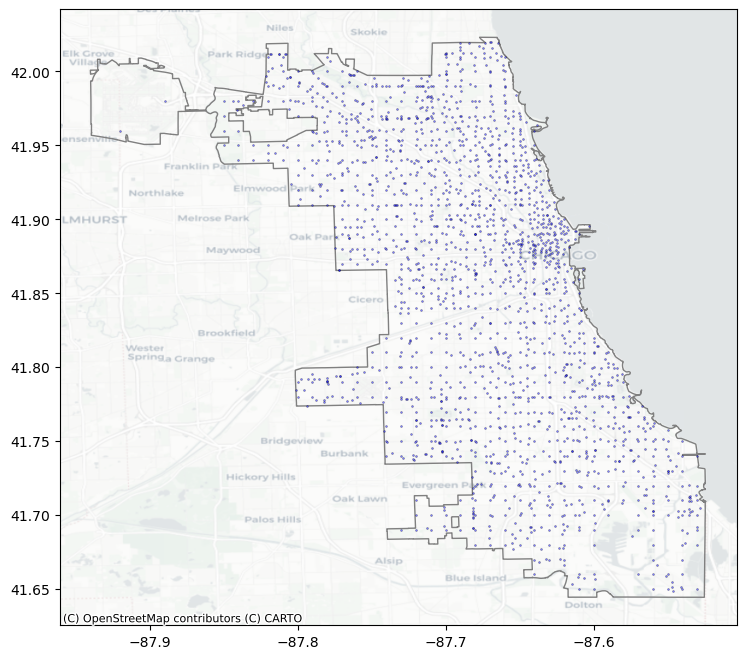

In [61]:
#Station Distribution Map
fig, ax = plt.subplots(figsize=(12,8))
chicago.plot(ax=ax, edgecolor='gray', linewidth=1, facecolor='none')
stations_inner.plot(ax=ax,
                    markersize=2, color='blue', alpha=0.5,
                    edgecolor='black', linewidth=0.3)
# Add basemap
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron, alpha=0.7)

Normalisation of station coordinates

In [64]:
bikePre_Step1 = pd.read_csv("preprocessing process data/bikePre_Step1.csv")
combined_coord_freq = pd.read_csv("preprocessing process data/combined_coord_freq.csv")
stations = pd.read_csv("preprocessing process data/stations.csv")
stations_unique = pd.read_csv("preprocessing process data/stations_unique.csv")
stations_inner = pd.read_csv("preprocessing process data/stations_inner.csv")

In [65]:
#step1 Fill station name based on coordinates
# Create a dictionary that maps latitude and longitude to site names
coord_to_station_dict = dict(zip(zip(combined_coord_freq['lat'], combined_coord_freq['lng']), combined_coord_freq['station_name']))

# Find the index corresponding to the row with the missing station name.
# Retrieve the corresponding site name in the dictionary based on the coordinates and populate it
missing_start_indices = bikePre_Step1.index[bikePre_Step1['start_station_name'].isna()]
bikePre_Step1.loc[missing_start_indices, 'start_station_name'] = bikePre_Step1.loc[missing_start_indices].apply(lambda row: coord_to_station_dict.get((row['start_lat'], row['start_lng'])), axis=1)

missing_end_indices = bikePre_Step1.index[bikePre_Step1['end_station_name'].isna()]
bikePre_Step1.loc[missing_end_indices, 'end_station_name'] = bikePre_Step1.loc[missing_end_indices].apply(lambda row: coord_to_station_dict.get((row['end_lat'], row['end_lng'])), axis=1)

#step2 Fill in the normalised coordinates according to the station name
#Based on the start_station_name and station_name columns, the stations dataset is left-joined to the bikePre_Step1 dataset.
bikePre_Step1 = bikePre_Step1.merge(stations[['station_name', 'lat', 'lng']], how='left', left_on='start_station_name', right_on='station_name')

# Based on the end_station_name and station_name columns
bikePre_Step1 = bikePre_Step1.merge(stations[['station_name', 'lat', 'lng']], how='left', left_on='end_station_name', right_on='station_name', suffixes=('_start', '_end'))

# Delete secondary columns
bikePre_Step1.drop(columns=['station_name_start', 'station_name_end'], inplace=True)
bikePre_dropped = bikePre_Step1.drop(bikePre_Step1.columns[list(range(5, 9))], axis=1)

#step3 Adjust site names with duplicate locations
# Identify sites with duplicate coordinates
missing_start_stations = bikePre_dropped[~bikePre_dropped['start_station_name'].isin(stations_unique['station_name'])]
missing_end_stations = bikePre_dropped[~bikePre_dropped['end_station_name'].isin(stations_unique['station_name'])]

# Create a dictionary that maps latitude and longitude to site names
coord_to_station_dict = dict(zip(zip(stations_unique['lat'], stations_unique['lng']), stations_unique['station_name']))

# Based on the coordinates of the start and end stations, search for the correct station name in the dictionary and fill it in.
bikePre_dropped.loc[missing_start_stations.index, 'start_station_name'] = missing_start_stations.apply(lambda row: coord_to_station_dict.get((row['lat_start'], row['lng_start']), row['start_station_name']), axis=1)
bikePre_dropped.loc[missing_end_stations.index, 'end_station_name'] = missing_end_stations.apply(lambda row: coord_to_station_dict.get((row['lat_end'], row['lng_end']), row['end_station_name']), axis=1)

bikePre_dropped.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end
0,electric_bike,2023-01-21 20:05:42,2023-01-21 20:16:33,Lincoln Ave & Fullerton Ave,Hampden Ct & Diversey Ave,41.924161,-87.646380,41.932559,-87.642385
1,classic_bike,2023-01-10 15:37:36,2023-01-10 15:46:05,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383
2,electric_bike,2023-01-02 07:51:57,2023-01-02 08:05:11,Western Ave & Lunt Ave,Valli Produce - Evanston Plaza,42.008594,-87.690492,42.039742,-87.699413
3,classic_bike,2023-01-22 10:52:58,2023-01-22 11:01:44,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383
4,classic_bike,2023-01-12 13:58:01,2023-01-12 14:13:20,Kimbark Ave & 53rd St,Greenwood Ave & 47th St,41.799568,-87.594747,41.809835,-87.599383


In [66]:
missing_data = check_missing_values(bikePre_dropped)
missing_data

,Missing Ratio


In [69]:
# Deletion of trips whose start or end station is not within the city boundary
# Delete rows with start_station_name/end_station_name values that are not in stations_inner
bike_inner = bikePre_dropped[bikePre_dropped['start_station_name'].isin(stations_inner['station_name'])]
bike_inner = bike_inner[bike_inner['end_station_name'].isin(stations_inner['station_name'])]

#bike_inner.to_csv('preprocessing process data/bikePre_Step2.csv', index=False)
bike_inner.shape

(6259421, 9)

In [68]:
start_stations_not_in_inner = bike_inner[~bike_inner['start_station_name'].isin(stations_inner['station_name'])]
print("Start Stations not in stations_inner:")
print(start_stations_not_in_inner['start_station_name'].unique())

start_station_unique = bike_inner['start_station_name'].unique()
end_station_unique = bike_inner['end_station_name'].unique()
start_station_count = len(start_station_unique)
end_station_count = len(end_station_unique)
print("Start Station Unique Count:", start_station_count)
print("End Station Unique Count:", end_station_count)

unique_stations = pd.concat([bike_inner['start_station_name'], bike_inner['end_station_name']]).unique()
num_unique_stations = len(unique_stations)
print("Total number of unique stations:", num_unique_stations)

Start Stations not in stations_inner:
[]
Start Station Unique Count: 1880
End Station Unique Count: 1891
Total number of unique stations: 1907


Feature Engineering

In [41]:
bikePre_Step2 = pd.read_csv("preprocessing process data/bikePre_Step2.csv")

In [42]:
#Temporal feature

# Return the season code according to the month (0-Spring, 1-Summer, 2-Autumn, 3-Winter)
def get_season_code(month):
    if month in [3, 4, 5]:
        return 0  # Spring
    elif month in [6, 7, 8]:
        return 1  # Summer
    elif month in [9, 10, 11]:
        return 2  # Autumn
    else:
        return 3  # Winter
    
def create_time_features(df):
    # Convert started_at and ended_at to datetime
    df.started_at = pd.to_datetime(df.started_at)
    df.ended_at = pd.to_datetime(df.ended_at)
    
    # Extract the month and year from the started_at column
    df['Year'] = df.started_at.dt.year
    df['Month'] = df.started_at.dt.month
    df['Season'] = df['Month'].apply(get_season_code)
    df['DayofMonth'] = df.started_at.dt.day
    df['DayofWeek'] = df.started_at.dt.weekday + 1
    df['Is_weekend'] = (df['DayofWeek'] >= 6).astype(int) #(1 for weekend, 0 for weekday)
    df['Hour'] = df.started_at.dt.hour

    
    # Calculate ride duration in minutes and round to the nearest integer
    df['Ride_Duration'] = ((df.ended_at - df.started_at).dt.total_seconds() / 60).round().astype(int)
    
    # Create bins for ride length
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    # Create a new column for ride length category
    df['Ride_Duration_Category'] = pd.cut(df['Ride_Duration'], bins, labels=names)
    #Label Encoding
    duration_mapping = {'<10': 0,'10-20': 1,'20-30': 2,'30-40': 3,'40-50': 4,'50-60': 5,'60+': 6}
    df['Ride_Duration_Category'] = df['Ride_Duration_Category'].map(duration_mapping)
    
    # sort
    df = df.sort_values(by=['started_at', 'start_station_name'])
    
    return df

bikePre_time = create_time_features(bikePre_Step2)
bikePre_time.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end,Year,Month,Season,DayofMonth,DayofWeek,Is_weekend,Hour,Ride_Duration,Ride_Duration_Category
79820,electric_bike,2023-01-01 00:01:58,2023-01-01 00:02:41,Unknown 33,Unknown 33,41.800000,-87.590000,41.800000,-87.590000,2023,1,3,1,7,1,0,1,0
187082,classic_bike,2023-01-01 00:02:06,2023-01-01 00:29:46,Fairbanks Ct & Grand Ave,New St & Illinois St,41.891847,-87.620580,41.890847,-87.618617,2023,1,3,1,7,1,0,28,2
182576,electric_bike,2023-01-01 00:03:26,2023-01-01 00:07:23,Sheridan Rd & Loyola Ave,Sheridan Rd & Loyola Ave,42.001044,-87.661198,42.001044,-87.661198,2023,1,3,1,7,1,0,4,0
105021,classic_bike,2023-01-01 00:04:07,2023-01-01 00:13:56,Leavitt St & Lawrence Ave,Broadway & Argyle St,41.968885,-87.684001,41.973815,-87.659660,2023,1,3,1,7,1,0,10,0
166899,electric_bike,2023-01-01 00:04:27,2023-01-01 00:16:52,Clark St & Montrose Ave,Clark St & Montrose Ave,41.961588,-87.666036,41.961588,-87.666036,2023,1,3,1,7,1,0,12,1


In [43]:
bikePre_time['Ride_Duration'].describe()

count    6.259421e+06
mean     1.487536e+01
std      3.669736e+01
min     -1.665700e+04
25%      5.000000e+00
50%      9.000000e+00
75%      1.600000e+01
max      1.213600e+04
Name: Ride_Duration, dtype: float64

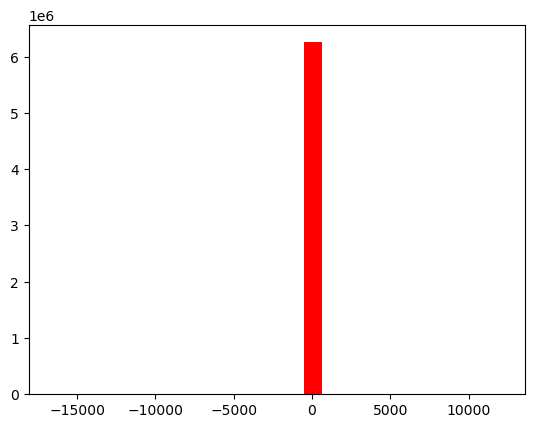

2.0
102.0
(5797191, 18)


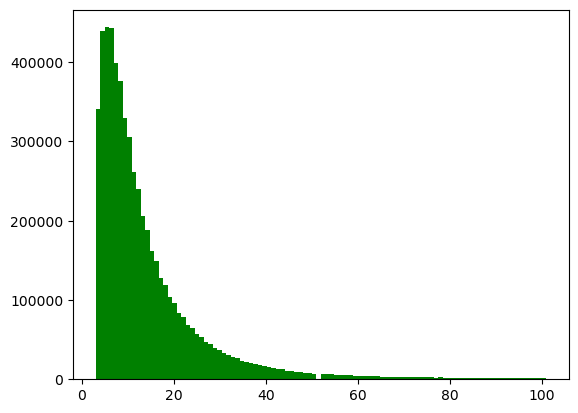

In [44]:
plt.hist(bikePre_time['Ride_Duration'], bins=25, color='red')
plt.show()
print(bikePre_time['Ride_Duration'].quantile(.05))
print(bikePre_time['Ride_Duration'].quantile(.992))
long_duration = bikePre_time[
    (bikePre_time['Ride_Duration'] > bikePre_time['Ride_Duration'].quantile(.05)) &
    (bikePre_time['Ride_Duration'] < bikePre_time['Ride_Duration'].quantile(.992))]
print(long_duration.shape)
plt.hist(long_duration['Ride_Duration'], bins=100, color='green')
plt.show()

In [45]:
#Remove time outliers

# Count rows where Ride_Duration is less than zero
negative_duration_count = len(bikePre_time[bikePre_time['Ride_Duration'] < 0])
print(f"Number of rows with Ride_Duration less than zero: {negative_duration_count}")

# Count rows where Ride_Duration is less than 2 minutes or greater than 180 minutes
short_rides_count = len(bikePre_time[bikePre_time['Ride_Duration'] < 2])
long_rides_count = len(bikePre_time[bikePre_time['Ride_Duration'] > 100])
print(f"Number of rides less than 2 minutes: {short_rides_count}")
print(f"Number of rides greater than 180 minutes: {long_rides_count}")


def remove_time_outliers(df):
    # Remove rows where Ride_Duration is less than zero
    df = df[df['Ride_Duration'] >= 0]
    
    # Remove rows where Ride_Duration is less than 2 minutes or greater than 180 minutes
    df = df[(df['Ride_Duration'] >= 2) & (df['Ride_Duration'] <= 100)]
    
    return df

bikePre_time = remove_time_outliers(bikePre_time)

bikePre_time.to_csv('preprocessing process data/bikePre_time.csv', index=False)
bikePre_time.shape

Number of rows with Ride_Duration less than zero: 141
Number of rides less than 2 minutes: 211529
Number of rides greater than 180 minutes: 51336


(5996556, 18)

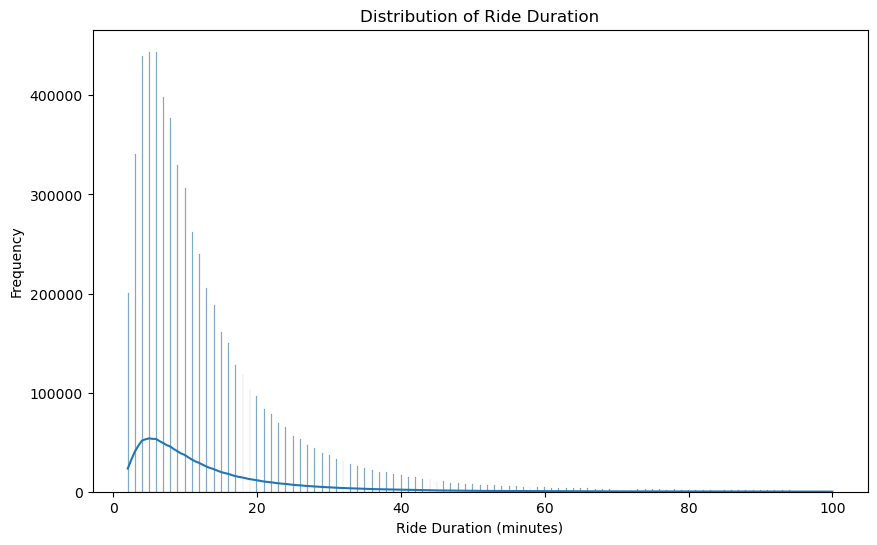

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(bikePre_time['Ride_Duration'], kde=True)
plt.title('Distribution of Ride Duration')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [48]:
bikePre_time = pd.read_csv("preprocessing process data/bikePre_time.csv")

#spatial feature
def calculate_ride_distances(df, start_lat_column, start_lng_column, end_lat_column, end_lng_column):
   
    # Define a function to calculate the distance between two coordinates
    def calculate_ride_distance(start_coords, end_coords):
        return geodesic(start_coords, end_coords).kilometers
    
    # Convert DataFrame rows to a list of tuples for iteration with tqdm
    coords_list = df[[start_lat_column, start_lng_column, end_lat_column, end_lng_column]].values.tolist()

    # Use a list comprehension with tqdm to calculate distances and display progress
    distances = [calculate_ride_distance((lat_start, lng_start), (lat_end, lng_end)) for lat_start, lng_start, lat_end, lng_end in tqdm(coords_list, desc="Calculating Distances")]

    # Assign the calculated distances to a new column in the DataFrame copy
    df['Ride_distance_km'] = distances

    return df

def create_distance_features(df):
    
    # Calculate ride distance
    df = calculate_ride_distances(df, 'lat_start', 'lng_start', 'lat_end', 'lng_end')
    
    # Create bins for distance
    distance_bins = [0, 1, 2, 3, 4, 5, np.inf]
    distance_names = ['<1', '1-2', '2-3', '3-4', '4-5', '5+']

    # Create a new column for distance category
    df['Ride_distance_category'] = pd.cut(df['Ride_distance_km'], distance_bins, labels=distance_names)
    
    distance_mapping = {'<1': 0,'1-2': 1,'2-3': 2,'3-4': 3,'4-5': 4,'5+': 5}
    df['Ride_distance_category'] = df['Ride_distance_category'].map(distance_mapping)
    return df

bikePre_distance = create_distance_features(bikePre_time)
bikePre_distance.head()

Calculating Distances: 100%|██████████| 5996556/5996556 [09:17<00:00, 10754.83it/s]


,rideable_type,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end,Year,Month,Season,DayofMonth,DayofWeek,Is_weekend,Hour,Ride_Duration,Ride_Duration_Category,Ride_distance_km,Ride_distance_category
187082,classic_bike,2023-01-01 00:02:06,2023-01-01 00:29:46,Fairbanks Ct & Grand Ave,New St & Illinois St,41.891847,-87.620580,41.890847,-87.618617,2023,1,3,1,7,1,0,28,2,0.197220,0
182576,electric_bike,2023-01-01 00:03:26,2023-01-01 00:07:23,Sheridan Rd & Loyola Ave,Sheridan Rd & Loyola Ave,42.001044,-87.661198,42.001044,-87.661198,2023,1,3,1,7,1,0,4,0,0.000000,NaN
105021,classic_bike,2023-01-01 00:04:07,2023-01-01 00:13:56,Leavitt St & Lawrence Ave,Broadway & Argyle St,41.968885,-87.684001,41.973815,-87.659660,2023,1,3,1,7,1,0,10,0,2.090565,2
166899,electric_bike,2023-01-01 00:04:27,2023-01-01 00:16:52,Clark St & Montrose Ave,Clark St & Montrose Ave,41.961588,-87.666036,41.961588,-87.666036,2023,1,3,1,7,1,0,12,1,0.000000,NaN
18130,classic_bike,2023-01-01 00:04:54,2023-01-01 00:31:52,State St & Randolph St,Indiana Ave & Roosevelt Rd,41.884621,-87.627834,41.867888,-87.623041,2023,1,3,1,7,1,0,27,2,1.900671,1


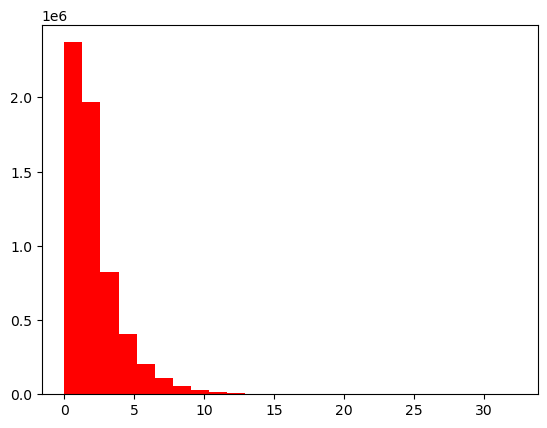

0.0
10.22180935924302
(5725060, 20)


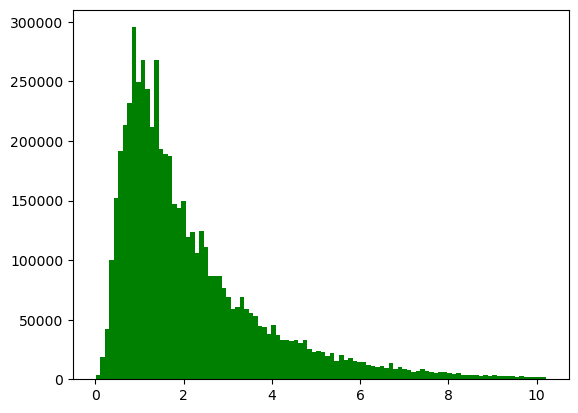

In [49]:
plt.hist(bikePre_distance['Ride_distance_km'], bins=25, color='red')
plt.show()
print(bikePre_distance['Ride_distance_km'].quantile(.0))
print(bikePre_distance['Ride_distance_km'].quantile(.995))
long_distance = bikePre_distance[
    (bikePre_distance['Ride_distance_km'] > bikePre_distance['Ride_distance_km'].quantile(.0)) &
    (bikePre_distance['Ride_distance_km'] < bikePre_distance['Ride_distance_km'].quantile(.995))]
print(long_distance.shape)
plt.hist(long_distance['Ride_distance_km'], bins=100, color='green')
plt.show()

In [50]:
#Remove distance outliers

# Count rows where travel_distance is less than 0.15 Km or greater than 10 Km
short_dis_count = len(bikePre_distance[bikePre_distance['Ride_distance_km'] < 0.15])
long_dis_count = len(bikePre_distance[bikePre_distance['Ride_distance_km'] > 10])
print(f"Number of rides less than 0.15 Km: {short_dis_count}")
print(f"Number of rides greater than 10 Km: {long_dis_count}")

def remove_distance_outliers(df):
    
    # Remove rows where travel_distance is less than 0.15 Km or greater than 10 Km
    df = df[(df['Ride_distance_km'] >= 0.15) & (df['Ride_distance_km'] <= 10)]
    
    return df

bikePre_distance = remove_distance_outliers(bikePre_distance)

bikePre_distance.to_csv('preprocessing process data/bikePre_distance.csv', index=False)
bikePre_distance.shape

Number of rides less than 0.15 Km: 249599
Number of rides greater than 10 Km: 34183


(5712774, 20)

In [28]:
stations_inner = pd.read_csv("preprocessing process data/stations_inner.csv")
metro_stations = pd.read_csv("raw data/MetroStation_unique.csv")
bus_stops = pd.read_csv("raw data/BusStop_unique.csv")

# Calculate the distance to the nearest station, metro station and bus stop.
def find_nearest_bike_station(stations):
    """
    Find the nearest bike station for each bike station in the DataFrame and calculate the distance.

    Parameters:
        stations (DataFrame): The DataFrame containing station data.

    Returns:
        DataFrame: A copy of the original DataFrame with new columns 'nearest_station' and 'nearest_distance_km'.
    """
    # Define a function to calculate the distance between two coordinates
    def calculate_distance(coord1, coord2):
        return geodesic(coord1, coord2).kilometers

    # Create new columns to store the nearest station's name and distance
    stations['nearest_station'] = None
    stations['nearest_distance_km'] = float('inf')

    # Iterate over each station to find the nearest station and calculate the distance
    for index, station in tqdm(stations.iterrows(), total=len(stations), desc="Calculating Nearest Stations"):
        station_coord = (station['lat'], station['lng'])
        min_distance = float('inf')
        nearest_station_name = None

        # Calculate the distance between the current station and other stations
        for idx, neighbor in stations.iterrows():
            if index != idx:  # Exclude itself
                neighbor_coord = (neighbor['lat'], neighbor['lng'])
                distance = calculate_distance(station_coord, neighbor_coord)

                # Update the nearest distance and nearest station name if a closer station is found
                if distance < min_distance:
                    min_distance = distance
                    nearest_station_name = neighbor['station_name']

        # Save the nearest station and distance to the DataFrame
        stations.at[index, 'nearest_station'] = nearest_station_name
        stations.at[index, 'nearest_distance_km'] = min_distance

    return stations

def find_nearest_public_station(dataframe, stations, station_type):
    """
    Find the nearest public transport station for each bike station in the DataFrame and calculate the distance.

    Parameters:
        dataframe (DataFrame): The DataFrame containing station data.
        stations (DataFrame): The DataFrame containing station coordinates.
        station_type (str): The type of station being searched (e.g., "metro", "bus").

    Returns:
        DataFrame: A copy of the original DataFrame with new columns 'nearest_station' and 'nearest_distance_km'.
    """
    # Define a function to calculate the distance between two coordinates
    def calculate_distance(coord1, coord2):
        return geodesic(coord1, coord2).kilometers

    # Create new columns to store the nearest station's name and distance
    dataframe[f'nearest_{station_type}_station'] = None
    dataframe[f'nearest_{station_type}_distance_km'] = float('inf')

    # Iterate over each station to find the nearest station and calculate the distance
    for index, station in tqdm(dataframe.iterrows(), total=len(dataframe), desc=f"Calculating Nearest {station_type.capitalize()} Stations"):
        station_coord = (station['lat'], station['lng'])
        min_distance = float('inf')
        nearest_station_name = None

        # Calculate the distance between the current station and other stations
        for _, neighbor in stations.iterrows():
            neighbor_coord = (neighbor['latitude'], neighbor['longitude'])
            distance = calculate_distance(station_coord, neighbor_coord)

            # Update the nearest distance and nearest station name if a closer station is found
            if distance < min_distance:
                min_distance = distance
                nearest_station_name = neighbor['Station_name']

        # Save the nearest station and distance to the DataFrame
        dataframe.at[index, f'nearest_{station_type}_station'] = nearest_station_name
        dataframe.at[index, f'nearest_{station_type}_distance_km'] = min_distance

    return dataframe

# Find nearest neighbour and distance for each station
stations_with_nearest = find_nearest_bike_station(stations_inner.copy())

# Find the nearest metro station and distance for each station
stations_with_nearest_metro = find_nearest_public_station(stations_with_nearest.copy(), metro_stations, "metro")

# Find the nearest bus stop and distance for each station
stations_with_nearest_bus = find_nearest_public_station(stations_with_nearest_metro.copy(), bus_stops, "bus")

stations_inner_nearest = stations_with_nearest_bus
stations_inner_nearest.to_csv('preprocessing process data/stations_inner_nearest.csv', index=False)
stations_inner_nearest.head()

Calculating Nearest Bus Stations: 100%|██████████| 1909/1909 [24:51<00:00,  1.28it/s]


,station_name,lat,lng,geometry,nearest_station,nearest_distance_km,nearest_metro_station,nearest_metro_distance_km,nearest_bus_station,nearest_bus_distance_km
0,Streeter Dr & Grand Ave,41.892278,-87.612043,POINT (-87.612043 41.892278),Streeter Dr/Grand Ave,0.031724,Millennium Station,1.269610,Grand & Streeter,0.030427
1,DuSable Lake Shore Dr & Monroe St,41.880958,-87.616743,POINT (-87.616743 41.880958),Unknown 20,0.290536,Millennium Station,0.649402,Randolph & Field Blvd,0.405638
2,DuSable Lake Shore Dr & North Blvd,41.911722,-87.626804,POINT (-87.62680400000001 41.911722),Unknown 3,0.326944,Millennium Station,3.053206,Lake Shore & North Ave,0.141935
3,Clark St & Elm St,41.902973,-87.631280,POINT (-87.63128 41.902973),N Clark St & W Elm St,0.007999,Millennium Station,2.174727,Clark & Elm,0.035290
4,Kingsbury St & Kinzie St,41.889177,-87.638506,POINT (-87.6385057718 41.88917683258),Unknown 16,0.154073,Ogilvie,0.705318,Orleans & Hubbard,0.151773


In [51]:
#stations_inner_nearest = pd.read_csv("preprocessing process data/stations_inner_nearest.csv")
#bikePre_distance = pd.read_csv("preprocessing process data/bikePre_distance.csv")

# Spatial information links
bikePre_spatial = pd.merge(bikePre_distance, stations_inner_nearest[['station_name', 'nearest_distance_km', 'nearest_metro_distance_km', 'nearest_bus_distance_km']], left_on='start_station_name', right_on='station_name', how='left')
bikePre_spatial = bikePre_spatial.drop(columns=['station_name'])

bikePre_spatial.to_csv('preprocessing process data/bikePre_spatial.csv', index=False)
bikePre_spatial.head()

,rideable_type,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end,Year,...,DayofWeek,Is_weekend,Hour,Ride_Duration,Ride_Duration_Category,Ride_distance_km,Ride_distance_category,nearest_distance_km,nearest_metro_distance_km,nearest_bus_distance_km
0,classic_bike,2023-01-01 00:02:06,2023-01-01 00:29:46,Fairbanks Ct & Grand Ave,New St & Illinois St,41.891847,-87.620580,41.890847,-87.618617,2023,...,7,1,0,28,2,0.197220,0,0.188052,0.855933,0.047432
1,classic_bike,2023-01-01 00:04:07,2023-01-01 00:13:56,Leavitt St & Lawrence Ave,Broadway & Argyle St,41.968885,-87.684001,41.973815,-87.659660,2023,...,7,1,0,10,0,2.090565,2,0.354014,0.795768,0.013468
2,classic_bike,2023-01-01 00:04:54,2023-01-01 00:31:52,State St & Randolph St,Indiana Ave & Roosevelt Rd,41.884621,-87.627834,41.867888,-87.623041,2023,...,7,1,0,27,2,1.900671,1,0.155232,0.394475,0.030211
3,electric_bike,2023-01-01 00:05:11,2023-01-01 00:16:59,Unknown 65,Unknown 72,41.960000,-87.660000,41.990000,-87.670000,2023,...,7,1,0,12,1,3.433717,3,0.449612,1.502206,0.427672
4,electric_bike,2023-01-01 00:05:43,2023-01-01 00:21:37,Wabash Ave & Grand Ave,Streeter Dr & Grand Ave,41.891466,-87.626761,41.892278,-87.612043,2023,...,7,1,0,16,1,1.224785,1,0.151362,0.844548,0.099240


In [53]:
#Link weather data
Weather = pd.read_csv("raw data/Weather_cleaned.csv")
bikePre_spatial = pd.read_csv('preprocessing process data/bikePre_spatial.csv')
Weather.head()

,Timestamp,Year,Month,Day,Hour,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure
0,2022-12-31 18:00:00,2022,12,31,18,1.59,2.356667,0.00,82.44,3.28,99.12
1,2022-12-31 19:00:00,2022,12,31,19,1.86,2.356667,0.00,84.81,4.08,99.09
2,2022-12-31 20:00:00,2022,12,31,20,2.48,2.356667,0.00,84.94,4.44,99.05
3,2022-12-31 21:00:00,2022,12,31,21,2.84,2.356667,0.00,85.50,4.60,99.04
4,2022-12-31 22:00:00,2022,12,31,22,2.80,2.356667,0.02,87.56,4.91,99.03


In [54]:
bike_final = pd.merge(
    bikePre_spatial,
    Weather[['Year', 'Month', 'Day', 'Hour','Temp', 'Atemp', 'Prec', 'Humidity', 'Windspeed', 'AtmPressure']],  # 右侧数据集
    left_on=['Year', 'Month', 'DayofMonth', 'Hour'],
    right_on=['Year', 'Month', 'Day', 'Hour'],
    how='left'
)

# Delete 'Day' Column
bike_final.drop(columns=['Day'], inplace=True)

In [55]:
missing_data = check_missing_values(bike_final)
print(missing_data)
rows_with_missing_values = bike_final[bike_final.isna().any(axis=1)]
rows_with_missing_values

             Missing Ratio
Temp              0.012411
Atemp             0.012411
Prec              0.012411
Humidity          0.012411
Windspeed         0.012411
AtmPressure       0.012411


,rideable_type,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end,Year,...,Ride_distance_category,nearest_distance_km,nearest_metro_distance_km,nearest_bus_distance_km,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure
5712065,classic_bike,2024-03-31 18:00:06,2024-03-31 18:07:48,Wells St & Polk St,Federal St & Polk St,41.872732,-87.633516,41.872078,-87.629544,2024,...,0,0.256988,0.282240,0.258332,NaN,NaN,NaN,NaN,NaN,NaN
5712066,electric_bike,2024-03-31 18:00:08,2024-03-31 18:03:18,Logan Blvd & Elston Ave,Elston Ave & George St,41.929465,-87.684158,41.934003,-87.690823,2024,...,0,0.349954,1.905843,0.306348,NaN,NaN,NaN,NaN,NaN,NaN
5712067,electric_bike,2024-03-31 18:00:27,2024-03-31 18:06:39,LaSalle St & Illinois St,LaSalle St & Jackson Blvd,41.890762,-87.631697,41.878166,-87.631929,2024,...,1,0.164313,1.006695,0.034694,NaN,NaN,NaN,NaN,NaN,NaN
5712068,classic_bike,2024-03-31 18:00:36,2024-03-31 18:07:20,State St & Chicago Ave,Wells St & Elm St,41.896617,-87.628579,41.903222,-87.634324,2024,...,0,0.093043,1.434103,0.048154,NaN,NaN,NaN,NaN,NaN,NaN
5712069,classic_bike,2024-03-31 18:00:42,2024-03-31 18:05:15,Broadway & Barry Ave,Broadway & Cornelia Ave,41.937582,-87.644098,41.945529,-87.646439,2024,...,0,0.222338,3.010650,0.036258,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712769,electric_bike,2024-03-31 23:43:55,2024-03-31 23:46:36,Ashland Ave & 13th St,Unknown 106,41.865234,-87.666507,41.860000,-87.660000,2024,...,0,0.603592,1.691243,0.162179,NaN,NaN,NaN,NaN,NaN,NaN
5712770,electric_bike,2024-03-31 23:52:20,2024-03-31 23:57:00,Lincoln Ave & Roscoe St*,Clark St & Grace St,41.943350,-87.670668,41.950780,-87.659172,2024,...,1,0.085729,2.773609,0.171302,NaN,NaN,NaN,NaN,NaN,NaN
5712771,classic_bike,2024-03-31 23:54:44,2024-04-01 00:08:37,Racine Ave & 35th St,Racine Ave & 18th St,41.830689,-87.656211,41.858166,-87.656495,2024,...,3,0.323940,2.227288,0.065561,NaN,NaN,NaN,NaN,NaN,NaN
5712772,electric_bike,2024-03-31 23:56:47,2024-04-01 00:02:39,Clark St & Newport St,Wilton Ave & Belmont Ave,41.944540,-87.654678,41.940232,-87.652944,2024,...,0,0.484714,3.093671,0.029968,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
bike_final = bike_final.dropna()
bike_final.shape

(5712065, 29)

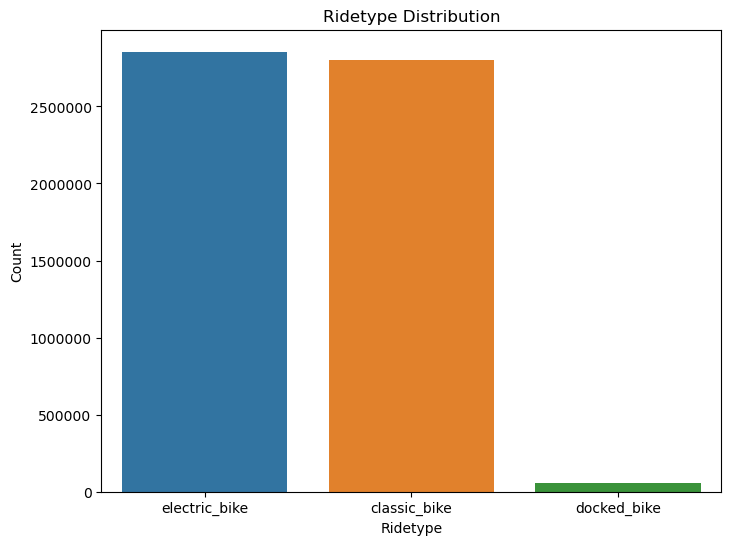

In [57]:
# Other
ridetype_counts = bike_final['rideable_type'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=ridetype_counts.index, y=ridetype_counts.values)
plt.title('Ridetype Distribution')
plt.xlabel('Ridetype')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

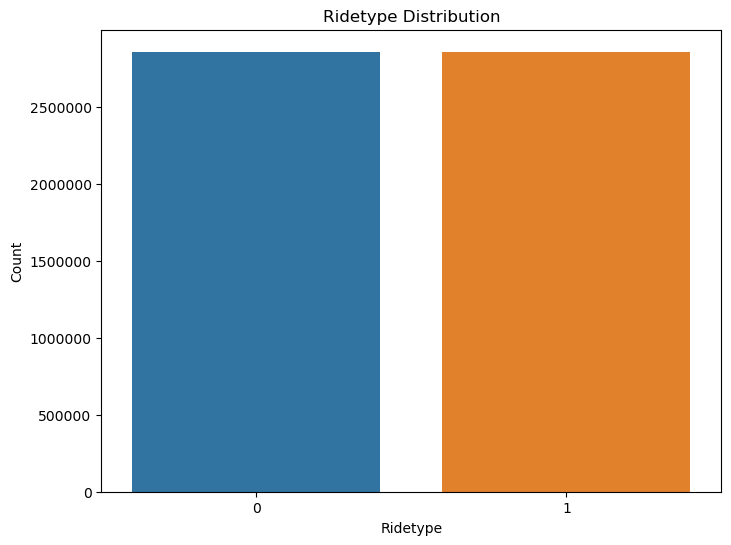

In [58]:
# Define a function to reclassify rideable_type
def reclassify_rideable_type(rideable_type):
    if rideable_type == 'electric_bike':
        return 1
    else:
        return 0

# Apply the function to the rideable_type column
bike_final['is_Ebike'] = bike_final['rideable_type'].apply(lambda x: reclassify_rideable_type(x))
bike_final.drop(columns=['rideable_type'], inplace=True)

# plot 
is_Ebike_counts = bike_final['is_Ebike'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=is_Ebike_counts.index, y=is_Ebike_counts.values)
plt.title('Ridetype Distribution')
plt.xlabel('Ridetype')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [59]:
bike_final.to_csv('bike_final.csv', index=False)
bike_final.head()

,started_at,ended_at,start_station_name,end_station_name,lat_start,lng_start,lat_end,lng_end,Year,Month,...,nearest_distance_km,nearest_metro_distance_km,nearest_bus_distance_km,Temp,Atemp,Prec,Humidity,Windspeed,AtmPressure,is_Ebike
0,2023-01-01 00:02:06,2023-01-01 00:29:46,Fairbanks Ct & Grand Ave,New St & Illinois St,41.891847,-87.620580,41.890847,-87.618617,2023,1,...,0.188052,0.855933,0.047432,2.37,3.966667,0.3,91.06,4.7,98.96,0
1,2023-01-01 00:04:07,2023-01-01 00:13:56,Leavitt St & Lawrence Ave,Broadway & Argyle St,41.968885,-87.684001,41.973815,-87.659660,2023,1,...,0.354014,0.795768,0.013468,2.37,3.966667,0.3,91.06,4.7,98.96,0
2,2023-01-01 00:04:54,2023-01-01 00:31:52,State St & Randolph St,Indiana Ave & Roosevelt Rd,41.884621,-87.627834,41.867888,-87.623041,2023,1,...,0.155232,0.394475,0.030211,2.37,3.966667,0.3,91.06,4.7,98.96,0
3,2023-01-01 00:05:11,2023-01-01 00:16:59,Unknown 65,Unknown 72,41.960000,-87.660000,41.990000,-87.670000,2023,1,...,0.449612,1.502206,0.427672,2.37,3.966667,0.3,91.06,4.7,98.96,1
4,2023-01-01 00:05:43,2023-01-01 00:21:37,Wabash Ave & Grand Ave,Streeter Dr & Grand Ave,41.891466,-87.626761,41.892278,-87.612043,2023,1,...,0.151362,0.844548,0.099240,2.37,3.966667,0.3,91.06,4.7,98.96,1
